In [177]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Tokenizer save point
tk_save='/content/drive/MyDrive/Final Project 4375/tokenizer_config.json'
# Load the dataset
df = pd.read_csv("ExtractedTweets.csv")

# Preprocessing and Setting up the Data

In [169]:
def preprocess_tweet(tweet):
    tweet = re.sub(r'\bRT\b', '', tweet)  # Remove 'RT' (retweet symbol)
    tweet = re.sub(r'@\w+', '', tweet)    # Remove '@' mentions
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  # Remove URLs
    return tweet.strip()

# Apply preprocessing to the 'Tweet' column of dataset
df['Tweet'] = df['Tweet'].apply(preprocess_tweet)

Tokenizing Inputs

In [170]:
# Tokenize the text
tokenizer = Tokenizer(num_words=20000) # Num of individual words the model is taking into account
tokenizer.fit_on_texts(df['Tweet'])
X = tokenizer.texts_to_sequences(df['Tweet'])
X = pad_sequences(X, maxlen=100)

# Save the tokenizer configuration
tokenizer_config = tokenizer.to_json()
with open(tk_save, 'w', encoding='utf-8') as f:
    f.write(tokenizer_config)

y = pd.get_dummies(df['Party']) # Convert outputs into one hot representations


Training/Testing Split

In [171]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Visualization

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


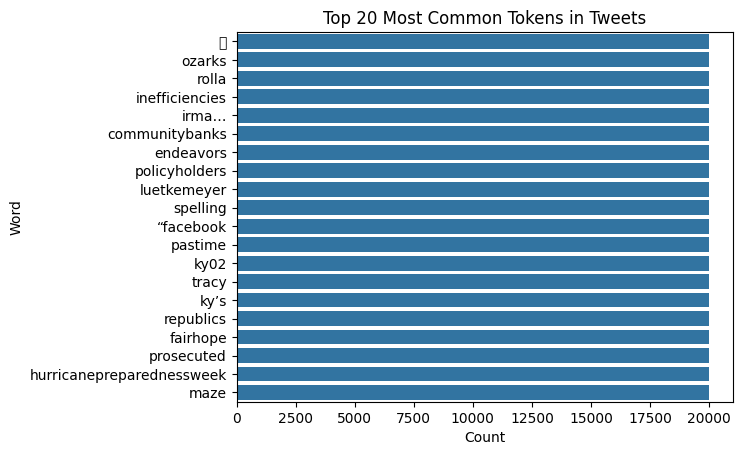

In [179]:
# Get the token counts from the tokenizer
word_index = tokenizer.word_index
word_counts = {word: index for word, index in word_index.items() if index < 20000}

# Create a DataFrame for visualization
word_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])

# Plot the most common tokens
top_tokens = word_df.nlargest(20, 'Count')  # Top 20 most common tokens
sns.barplot(x='Count', y='Word', data=top_tokens)
plt.title("Top 20 Most Common Tokens in Tweets")
plt.show()

Party
Republican    44392
Democrat      42068
Name: count, dtype: int64


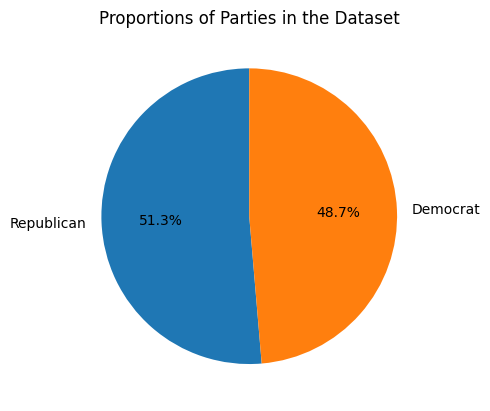

In [161]:
# Show data distribution
print(df['Party'].value_counts())

df['Party'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Proportions of Parties in the Dataset")
plt.ylabel("")  # To remove y-axis label
plt.show()

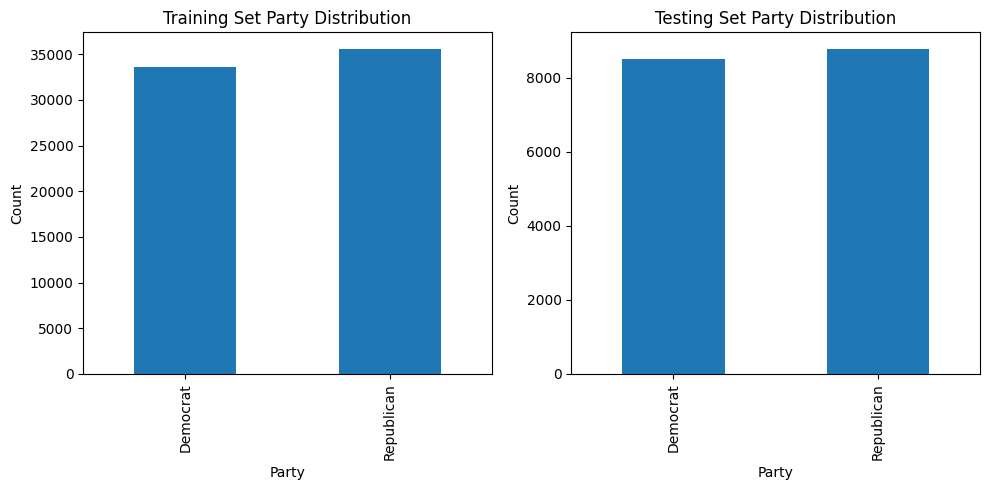

In [175]:
# Plot the distribution of parties in training and testing sets
train_dist = y_train.sum()
test_dist = y_test.sum()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

train_dist.plot.bar(ax=ax[0])
ax[0].set_title("Training Set Party Distribution")
ax[0].set_xlabel("Party")
ax[0].set_ylabel("Count")

test_dist.plot.bar(ax=ax[1])
ax[1].set_title("Testing Set Party Distribution")
ax[1].set_xlabel("Party")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

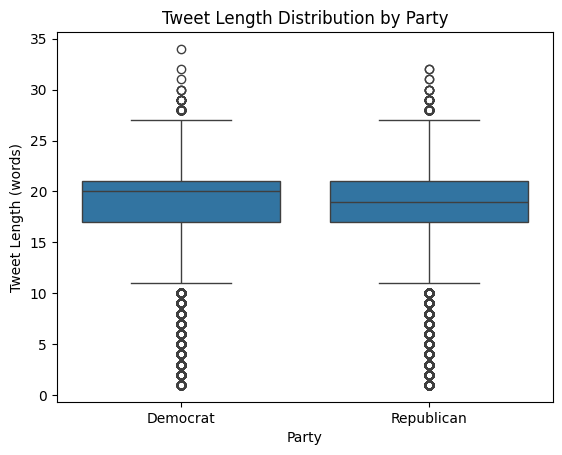

In [178]:
# Create a new column to indicate tweet length
df['Tweet_Length'] = df['Tweet'].apply(lambda x: len(x.split()))

# Plot tweet length distribution by party
sns.boxplot(x='Party', y='Tweet_Length', data=df)
plt.title("Tweet Length Distribution by Party")
plt.xlabel("Party")
plt.ylabel("Tweet Length (words)")
plt.show()

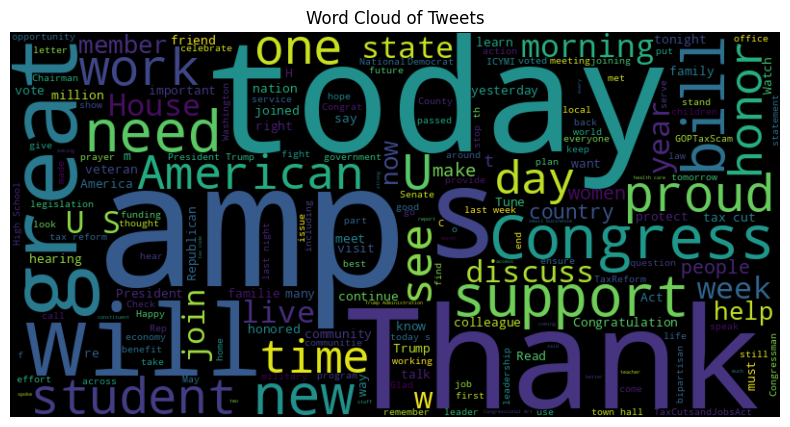

In [167]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df['Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets")
plt.show()

# Neural Network and Training

In [147]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    Flatten(),
    BatchNormalization(),
    Dropout(0.8),  # Increased dropout rate
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.8),  # Increased dropout rate
    Dense(2, activation='softmax')
])

In [146]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 100, 128)          2560000   
                                                                 
 flatten_24 (Flatten)        (None, 12800)             0         
                                                                 
 batch_normalization_27 (Ba  (None, 12800)             51200     
 tchNormalization)                                               
                                                                 
 dropout_45 (Dropout)        (None, 12800)             0         
                                                                 
 dense_66 (Dense)            (None, 128)               1638528   
                                                                 
 batch_normalization_28 (Ba  (None, 128)               512       
 tchNormalization)                                   

In [148]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)  # Learning rate scheduler
]

In [149]:
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [150]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size = 64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
865/865 [==============================] - 18s 18ms/step - loss: 1.3917 - accuracy: 0.5187 - val_loss: 0.9496 - val_accuracy: 0.5909 - lr: 0.0010
Epoch 2/10
865/865 [==============================] - 6s 7ms/step - loss: 0.9461 - accuracy: 0.6233 - val_loss: 0.8965 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 3/10
865/865 [==============================] - 5s 6ms/step - loss: 0.9184 - accuracy: 0.7172 - val_loss: 0.8857 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 4/10
865/865 [==============================] - 5s 5ms/step - loss: 0.9017 - accuracy: 0.7522 - val_loss: 0.9299 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 5/10
865/865 [==============================] - 5s 5ms/step - loss: 0.8967 - accuracy: 0.7725 - val_loss: 0.9281 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 6/10
865/865 [==============================] - 5s 5ms/step - loss: 0.7295 - accuracy: 0.8013 - val_loss: 0.7841 - val_accuracy: 0.7473 - lr: 5.0000e-04
Epoch 7/10
865/865 [==============================] - 5s 6ms/ste

In [151]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7473976612091064


# Results

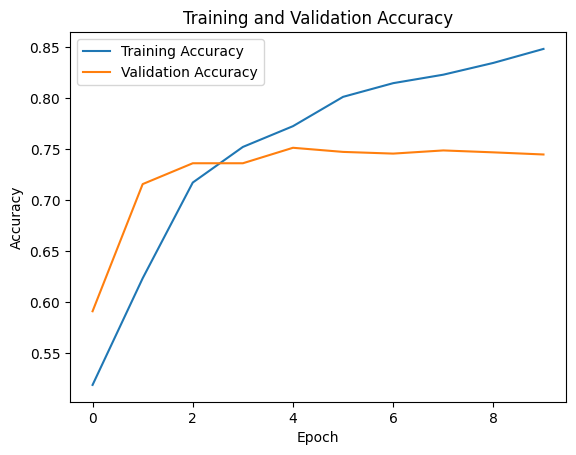

In [152]:
# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Tests

In [168]:

# Function to preprocess the input text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    return text

# Load the tokenizer used for training
tokenizer = Tokenizer(num_words=20000)

# Load tokenizer word index
with open(tk_save, 'r') as f:
    word_index = json.load(f)
    tokenizer.word_index = word_index

def predict_party(text):
    # Preprocess the input text
    processed_text = preprocess_text(text)

    # Tokenize and pad the processed text
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=100)

    # Predict the party lean
    party_prediction = model.predict(padded_sequences)[0]

    # Get the predicted class index
    predicted_class_index = np.argmax(party_prediction)

    # Get the probability of the predicted class
    predicted_probability = party_prediction[predicted_class_index]

    # Calculate the confidence percentage
    confidence_percentage = predicted_probability * 100


    # Map the predicted class index to party lean
    if predicted_class_index == 0:
        return "Democrat", confidence_percentage
    else:
        return "Republican", confidence_percentage


# User input
user_text = input("Enter the text to predict party lean: ")

# Predict party lean
predicted_party, party_percent = predict_party(user_text)
print("Predicted Party Lean:", predicted_party)
if party_percent is not None:
    print("Confidence Percentage:", "{:.2f}%".format(party_percent))


Enter the text to predict party lean: I am a republican
1/1 [==============================] - 0s 24ms/step
Predicted Party Lean: Republican
Confidence Percentage: 51.17%
